In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as nnf
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from util import load_MNIST

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

In [2]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_input3 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        h_       = self.LeakyReLU(self.FC_input3(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)

        return mean, log_var

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        h     = self.LeakyReLU(self.FC_hidden3(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [4]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        self.loss = []

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)
        z = mean + var*epsilon
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(z)

        return x_hat, mean, log_var

In [5]:
x_dim = 28
channels = 1

scale_factor = 2
x_inp_dim  = int(x_dim / scale_factor)


hidden_dim = 200
latent_dim = 80

lr = 1e-3
epochs = 100
batch_size = 4096

train_dataset, test_dataset, train_loader, test_loader, classes = load_MNIST(batch_size, None)
num_train_data = len(train_dataset)

In [6]:
encoder = Encoder(input_dim=x_inp_dim**2*channels, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim**2*channels)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [7]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, threshold=0.0001)

In [8]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x_inp = nnf.interpolate(x, size=(x_inp_dim, x_inp_dim), mode='bicubic', align_corners=False)
        x_inp = x_inp.view(-1, x_inp_dim**2*channels)
        x_inp = x_inp.to(DEVICE)

        x = x.view(-1, x_dim**2*channels)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x_inp)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item() / num_train_data

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print("\tEpoch", epoch, "complete!", "\tAverage Loss: ", overall_loss)

    model.loss.append(overall_loss)
    scheduler.step(overall_loss)

print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss)
print("Finish!!")

Start training VAE...


	Epoch 0 complete! 	Average Loss:  422.00173541666675
	Epoch 10 complete! 	Average Loss:  186.65577395833333
	Epoch 20 complete! 	Average Loss:  171.86108333333337
	Epoch 30 complete! 	Average Loss:  149.51505104166665
	Epoch 40 complete! 	Average Loss:  136.23073333333332
	Epoch 50 complete! 	Average Loss:  127.59548020833334
	Epoch 60 complete! 	Average Loss:  122.83467916666667
	Epoch 70 complete! 	Average Loss:  119.51200260416665
	Epoch 80 complete! 	Average Loss:  116.99741666666668
	Epoch 90 complete! 	Average Loss:  114.81316666666667
	Epoch 100 complete! 	Average Loss:  113.101134375
Finish!!


[]

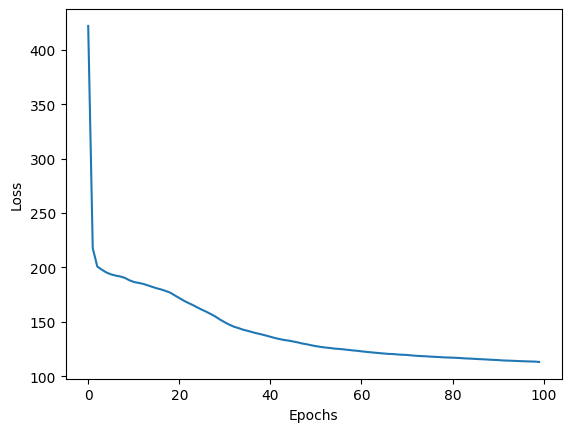

In [9]:
plt.plot(model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [10]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x_inp = nnf.interpolate(x, size=(x_inp_dim, x_inp_dim), mode='bicubic', align_corners=False)
        x_inp = x_inp.view(batch_size, x_inp_dim**2*channels)
        x_inp = x_inp.to(DEVICE)

        x = x.view(batch_size, x_dim**2*channels)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x_inp)

        break

  0%|          | 0/3 [00:00<?, ?it/s]


In [11]:
def show_image(x, x_inp, x_hat, n):
    x = x.view(batch_size, channels, x_dim, x_dim)
    x_inp = x_inp.view(batch_size, channels, x_inp_dim, x_inp_dim)
    x_hat = x_hat.view(batch_size, channels, x_dim, x_dim)


    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        axs[0, i].imshow(x[i].permute(1, 2, 0).cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(x_inp[i].permute(1, 2, 0).cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(x_hat[i].permute(1, 2, 0).cpu().numpy())
        axs[2, i].axis('off')

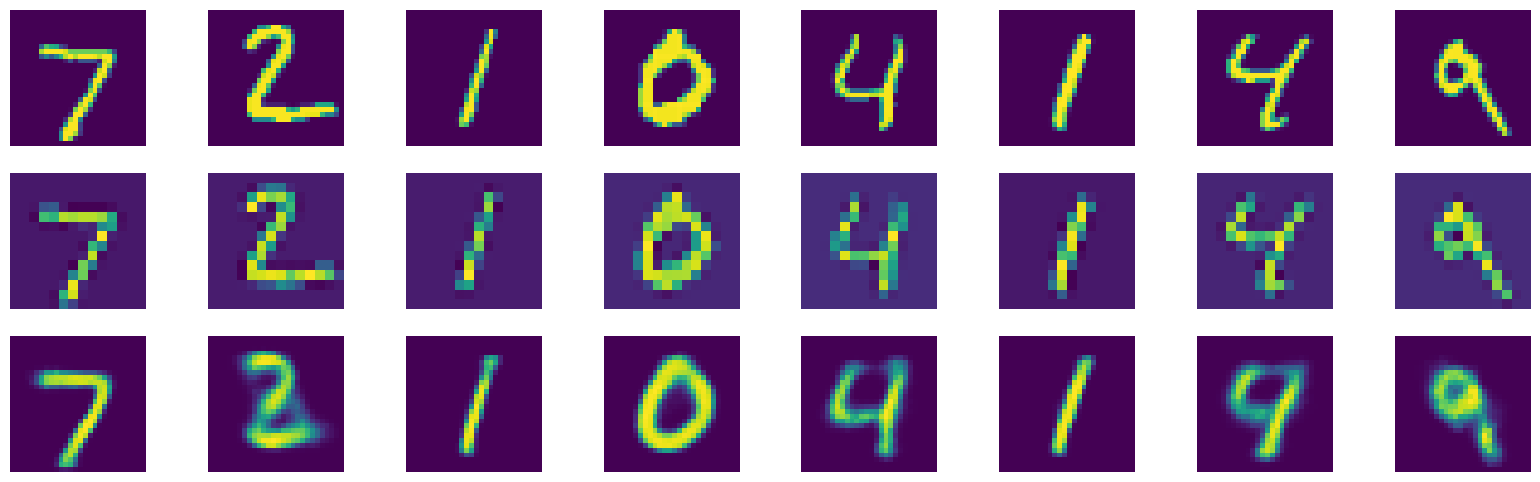

In [12]:
show_image(x, x_inp, x_hat, 8)

### Validation

#### Distortion (difference of generated image to ground truth)

##### Signal-to-Noise Ratio (PSNR)
higher better

In [ ]:
from piq import psnr

psnr_val = psnr(x, x_hat, data_range=1.0)
print(psnr_val)

tensor(11.9860, device='cuda:0')


##### Structural similarity index measure (SSIM)
higher better

In [ ]:
from piq import ssim

ssim_val = torch.mean(ssim(x, x_hat, data_range=1.0, reduction='none'))
print(ssim_val)

tensor(0.3786, device='cuda:0')


##### Learned Perceptual Image Patch Similarity (LPIPS)
lower better

2 versions

In [ ]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

lpips = LearnedPerceptualImagePatchSimilarity().to(DEVICE)
x_lpips = x * 2 - 1
x_lpips = x_lpips.repeat(1, 3, 1, 1)
x_lpips = nnf.pad(x_lpips, (2, 2, 2, 2), mode='reflect')

x_hat_lpips = x_hat * 2 - 1
x_hat_lpips = x_hat_lpips.repeat(1, 3, 1, 1)
x_hat_lpips = nnf.pad(x_hat_lpips, (2, 2, 2, 2), mode='reflect')

lpips_value = lpips(x_lpips, x_hat_lpips)
print(lpips_value)

tensor(0.1581, device='cuda:0')


In [ ]:
from piq import LPIPS

x_lpips = (x * 2) - 1
x_lpips = x_lpips.repeat(1, 3, 1, 1)
x_lpips = nnf.pad(x_lpips, (2, 2, 2, 2), mode='reflect')
# x_lpips = torch.rand(10, 3, 32, 32)
x_hat_lpips = (x_hat * 2) - 1
x_hat_lpips = x_hat_lpips.repeat(1, 3, 1, 1)
x_hat_lpips = nnf.pad(x_hat_lpips, (2, 2, 2, 2), mode='reflect')
# x_hat_lpips = torch.rand(10, 3, 32, 32)
lpips = LPIPS().to(DEVICE)
lpips_val = lpips(x_lpips, x_hat_lpips)
print(lpips_val)

tensor(0.2698, device='cuda:0')


#### Visual Quality

##### Blind/Referenceless Image Spatial Quality Evaluator (BRISQUE)
lower better

In [ ]:
from piq import brisque

brisque_val_gt = brisque(x)
print("ground_truth: ", brisque_val_gt)

brisque_val_hat = brisque(x_hat)
print("reconstructed: ", brisque_val_hat)

ground_truth:  tensor(72.9080, device='cuda:0')
reconstructed:  tensor(53.4652, device='cuda:0')


#### Consistency

##### Low Resolution Peak signal-to-noise ratio (LR-PSNR)
higher better

In [ ]:
from piq import psnr

x_hat_lr = nnf.interpolate(x_hat, size=(x_inp.size(2), x_inp.size(3)), mode='bicubic', align_corners=False)
x_hat_lr = (x_hat_lr - x_hat_lr.min()) / (x_hat_lr.max() - x_hat_lr.min())
psnr(x_inp, x_hat_lr, data_range=1.0)

tensor(13.9180, device='cuda:0')

#### Diversity (Average Pairwise distance between different samples coming from the same LR input (ADP))

##### Mean Squared Error (MSE)
higher better

In [ ]:
# Needs to be changed to calculate average over many reference images and the corresponding generated images

def MSE_diversity(reference, x_hat):
    # reference is 1 image, x_hat is N images
    # reshape reference to (N, C, H, W)
    x = reference.repeat(x_hat.size(0), 1, 1, 1)
    mse = nn.functional.mse_loss(x, x_hat, reduction='none')
    mse = mse.view(mse.size(0), -1).mean(1)
    return torch.mean(mse)

MSE_diversity(x[0], x_hat)

tensor(0.0464, device='cuda:0')

##### Learned Perceptual Image Patch Similarity (LPIPS)
higher better

In [ ]:
# Needs to be changed to calculate average over many reference images and the corresponding generated images
from piq import LPIPS

def LPIPS_diversity(reference, x_hat):
    # reference is 1 image, x_hat is N images
    # reshape reference to (N, C, H, W)
    reference = reference.repeat(x_hat.size(0), 3, 1, 1)
    reference = (reference * 2) - 1
    reference = nnf.pad(reference, (2, 2, 2, 2), mode='reflect')
                      
    x_hat_lpips = (x_hat * 2) - 1
    x_hat_lpips = x_hat_lpips.repeat(1, 3, 1, 1)
    x_hat_lpips = nnf.pad(x_hat_lpips, (2, 2, 2, 2), mode='reflect')
    lpips = LPIPS().to(DEVICE)
    return lpips(reference, x_hat_lpips)

LPIPS_diversity(x[0], x_hat)

tensor(0.2585, device='cuda:0')

In [ ]:
# from piq import LPIPS

# x_lpips = (x * 2) - 1
# x_lpips = x_lpips.repeat(1, 3, 1, 1)
# x_lpips = nnf.pad(x_lpips, (2, 2, 2, 2), mode='reflect')
# # x_lpips = torch.rand(10, 3, 32, 32)
# x_hat_lpips = (x_hat * 2) - 1
# x_hat_lpips = x_hat_lpips.repeat(1, 3, 1, 1)
# x_hat_lpips = nnf.pad(x_hat_lpips, (2, 2, 2, 2), mode='reflect')
# # x_hat_lpips = torch.rand(10, 3, 32, 32)
# lpips = LPIPS().to(DEVICE)
# lpips_val = lpips(x_lpips, x_hat_lpips)
# print(lpips_val)

In [ ]:
# from torchmetrics.image import StructuralSimilarityIndexMeasure

# def SSIM(x, x_hat):
#     ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
#     ssim_value = ssim(x, x_hat)
#     return ssim_value

ModuleNotFoundError: No module named 'torchmetrics'